# Homework 2
Connor Blake

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Problem 1

### a)

In [2]:
N = 7000
x = np.random.uniform(-3, 3, size=(N, 2)).astype(np.float32)
y = (np.sin(x[:, 0]) + np.sin(x[:, 1])).astype(np.float32).reshape(-1, 1)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

dataset = TensorDataset(x_tensor, y_tensor)

### b)

In [3]:
class SingleHiddenNet(nn.Module):
    def __init__(self, hidden_dim=32, depth=1, activation="relu"):
        super().__init__()
        act = {"relu": nn.ReLU(), "sigmoid": nn.Sigmoid(), "tanh": nn.Tanh(), "gelu": nn.GELU()}[activation.lower()]
        layers = [nn.Linear(2, hidden_dim), act]
        for _ in range(depth - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), act])
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
model = SingleHiddenNet(hidden_dim=32, activation="relu")
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

### c)

In [4]:
epochs = 300

In [5]:
def plot_loss_curve(activation_function, hidden_dim=32, hidden_depth=1):

    train_losses, test_losses = [], []
    model = SingleHiddenNet(hidden_dim=hidden_dim, depth=hidden_depth, activation=activation_function)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = random_split(dataset, [train_size, test_size])

    batch_size = 256
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        epoch_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train += loss.item() * len(xb)
        epoch_train /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            epoch_test = sum(
                criterion(model(xb), yb).item() * len(xb) for xb, yb in test_loader
            ) / len(test_loader.dataset)

        train_losses.append(epoch_train)
        test_losses.append(epoch_test)
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.yscale("log")
    plt.legend()
    plt.title(f"Loss Curve, activation={activation_function}, hidden_dim={hidden_dim}, depth={hidden_depth}")
    plt.show()
    return model

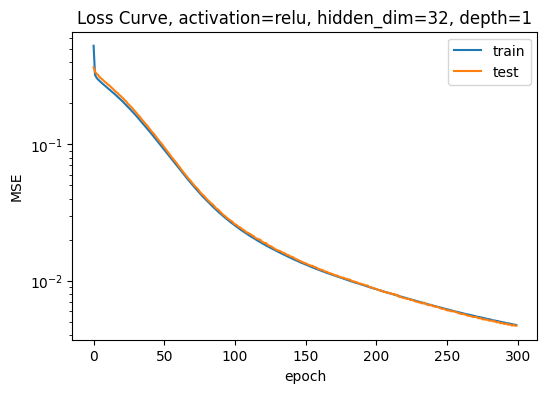

In [6]:
relu_model = plot_loss_curve("relu")

### d)

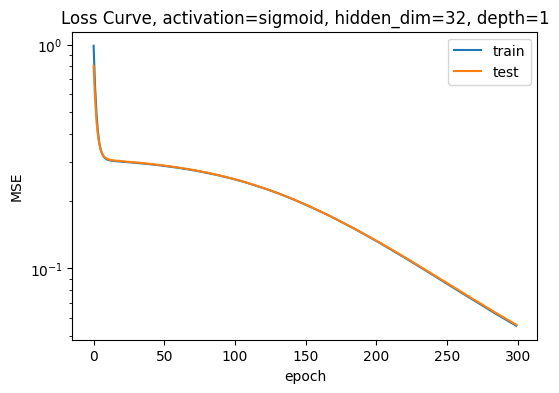

In [7]:
sigmoid_model = plot_loss_curve("sigmoid")

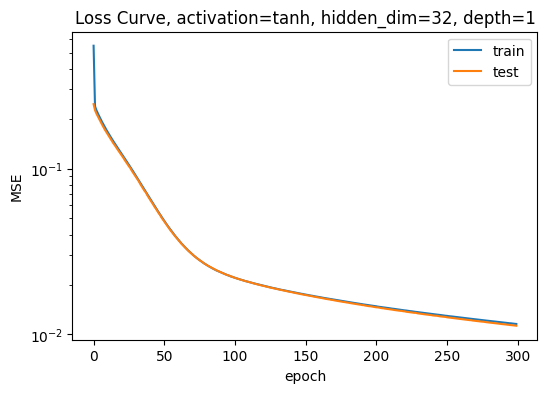

In [8]:
tanh_model = plot_loss_curve("tanh")

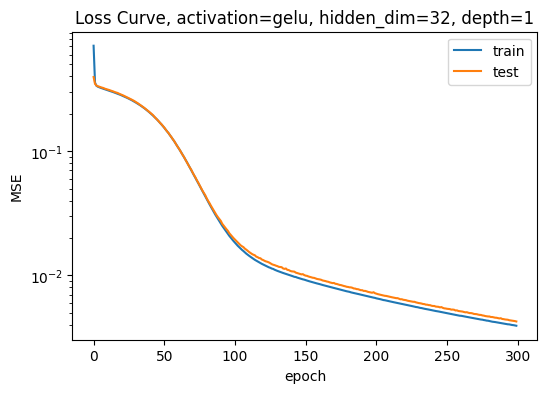

In [9]:
gelu_model = plot_loss_curve("gelu")

Gelu is the best model

### e)

In [10]:
def plot_contour_for_model(model, model_name):
    Nmesh = 200
    xs = np.linspace(-3, 3, Nmesh)
    X, Y = np.meshgrid(xs, xs)
    xt = torch.linspace(-3,3,Nmesh)
    Xt, Yt = torch.meshgrid(xt, xt, indexing="ij")
    torchgrid = torch.stack((Xt,Yt),dim=-1).reshape((-1,2))
    f_vals = np.sin(X) + np.sin(Y)
    with torch.no_grad():
        g_vals = model(torchgrid).reshape((Nmesh,Nmesh))
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    c1 = ax[0].contourf(X, Y, f_vals, levels=40)
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title("f(x,y) = sin(x) + sin(y)")
    c2 = ax[1].contourf(X, Y, g_vals, levels=40)
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title(f"{model_name} Model output g(x,y)")
    plt.show()

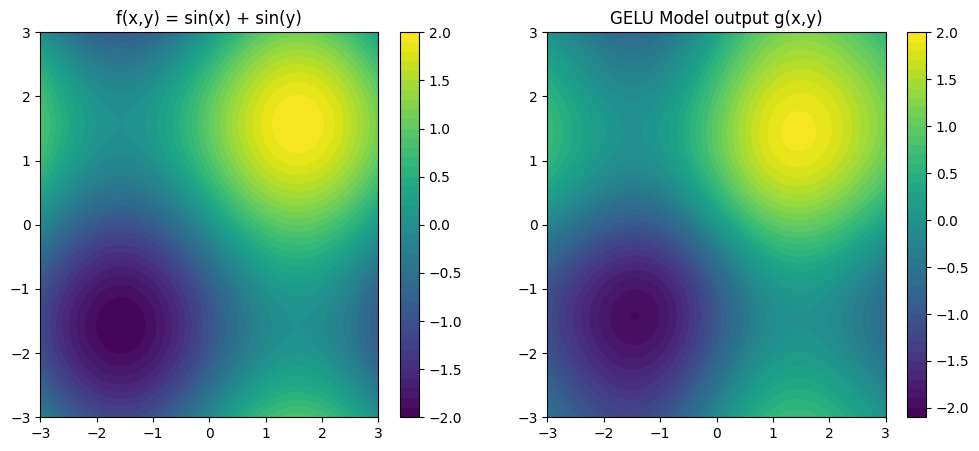

In [11]:
plot_contour_for_model(gelu_model, "GELU")

### f)

In [12]:
best_activation = "gelu"

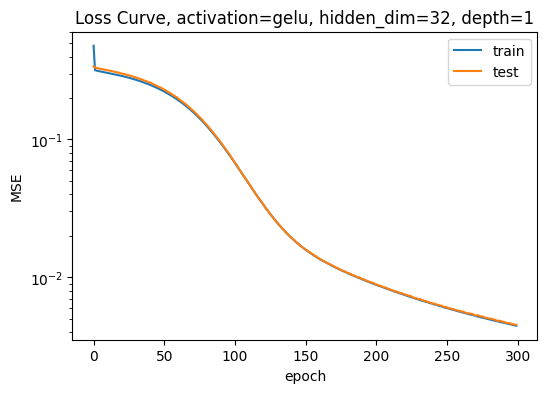

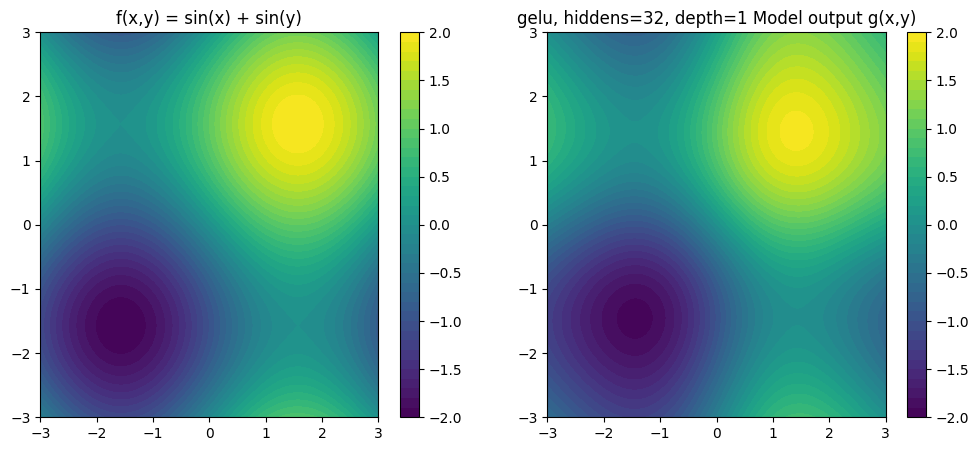

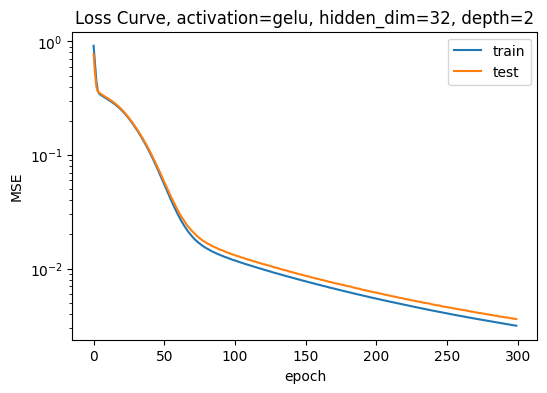

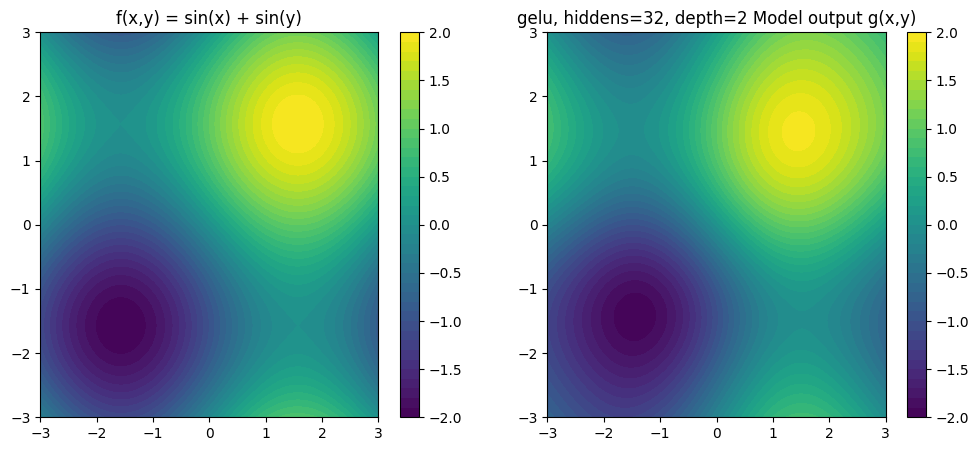

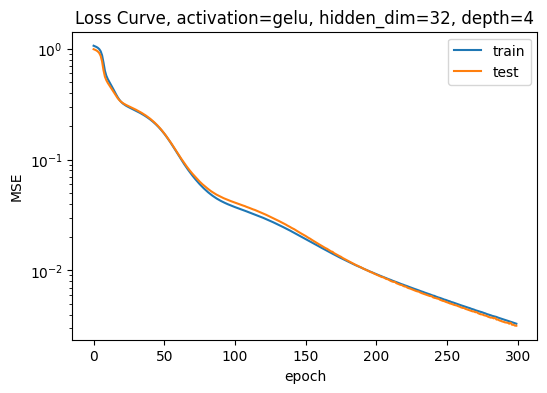

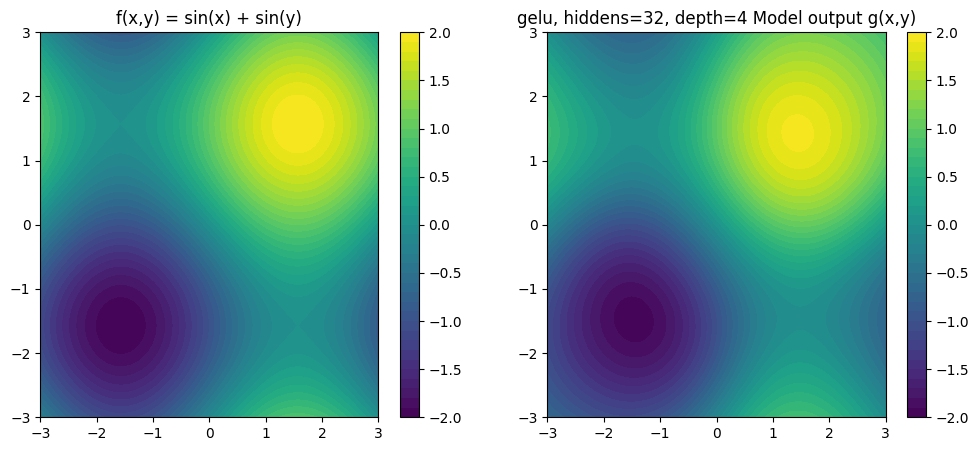

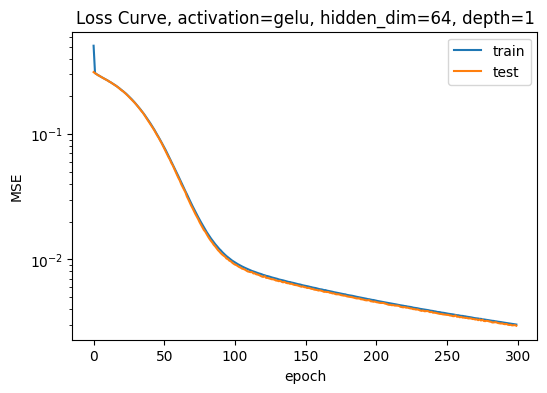

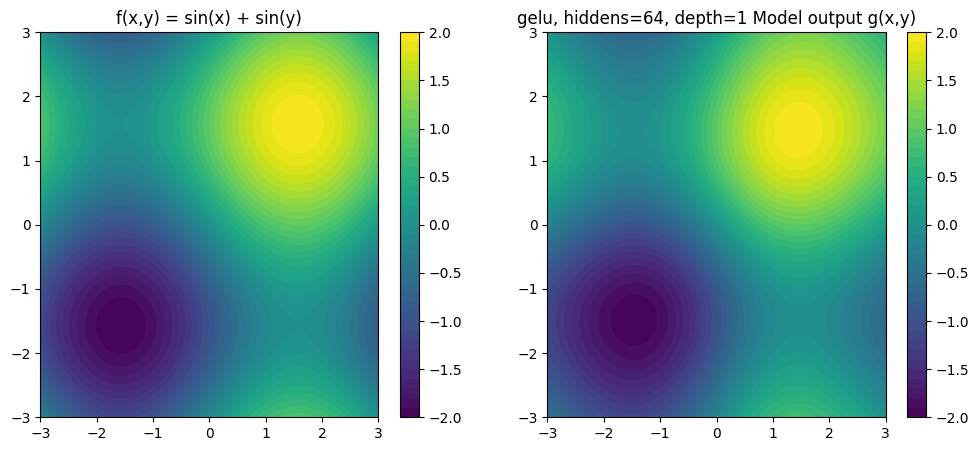

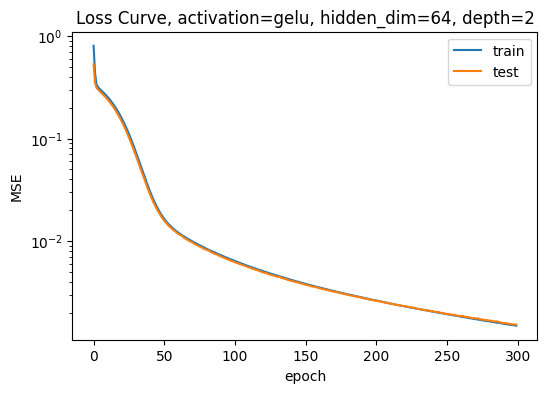

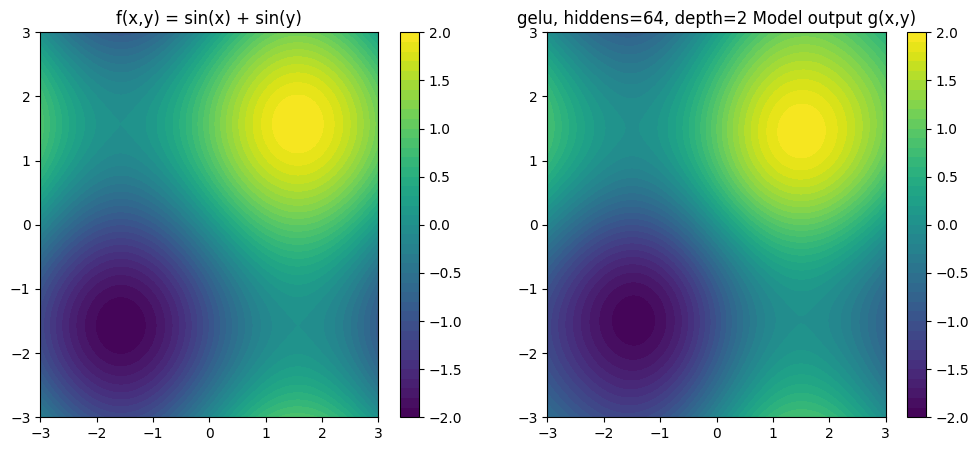

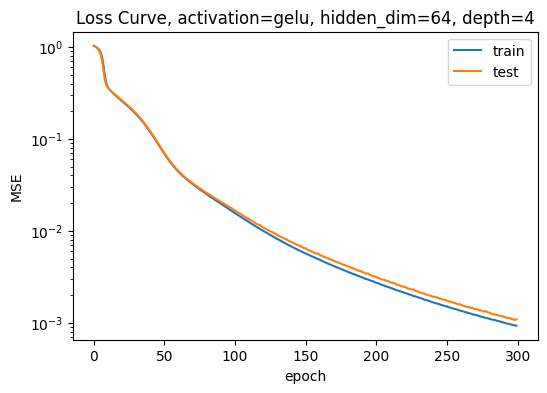

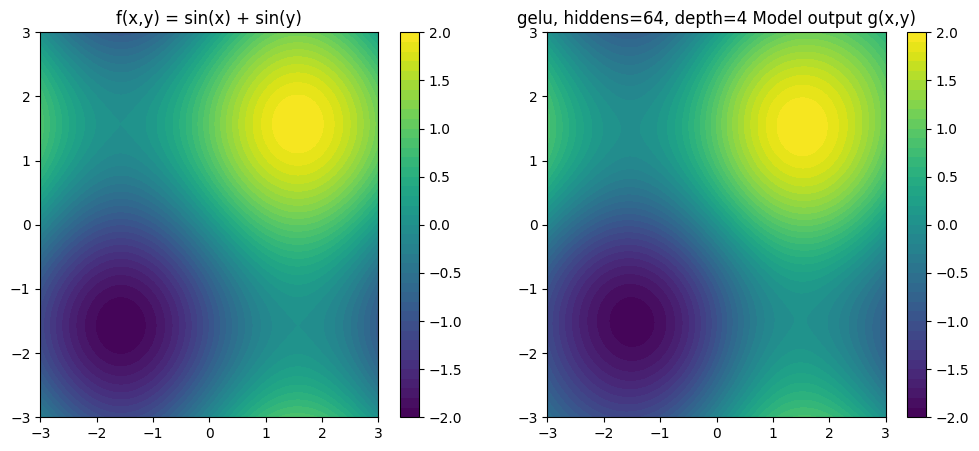

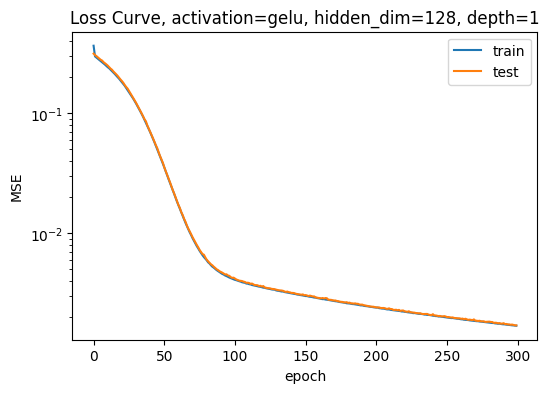

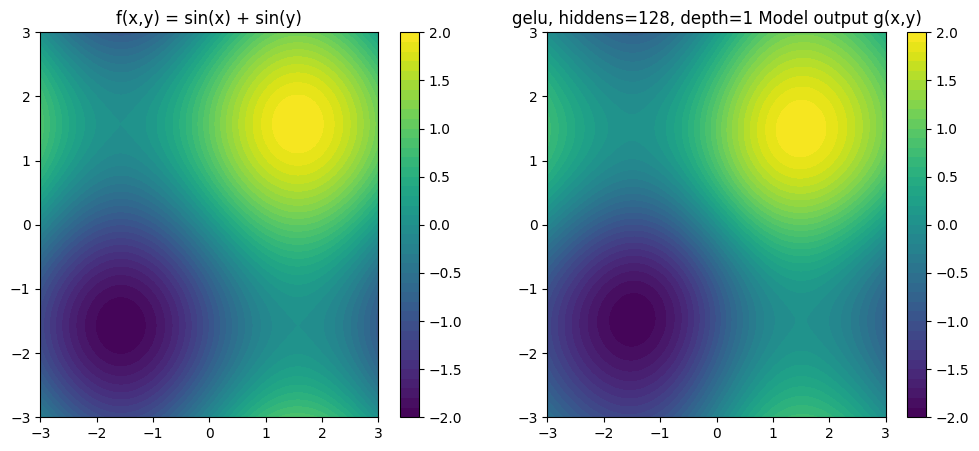

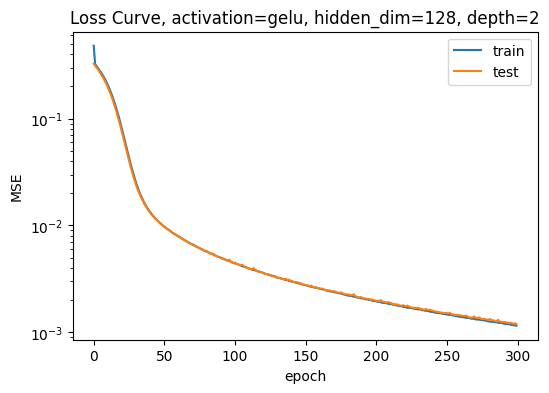

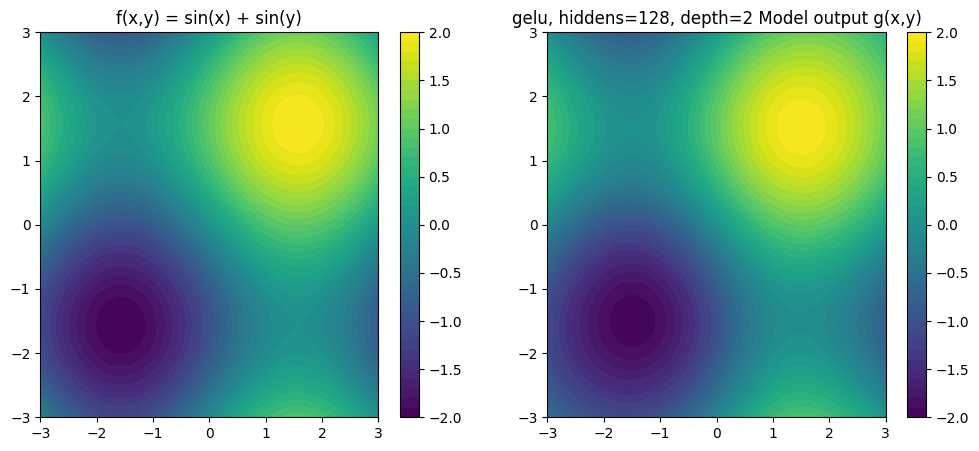

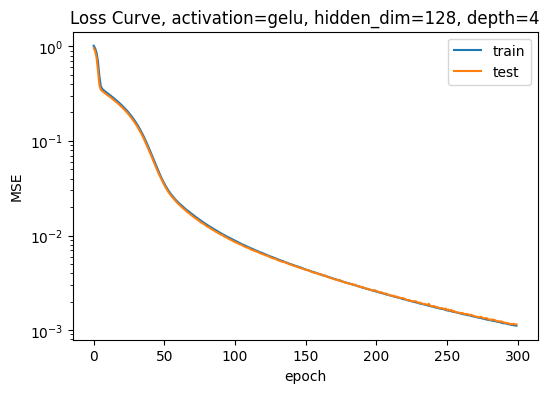

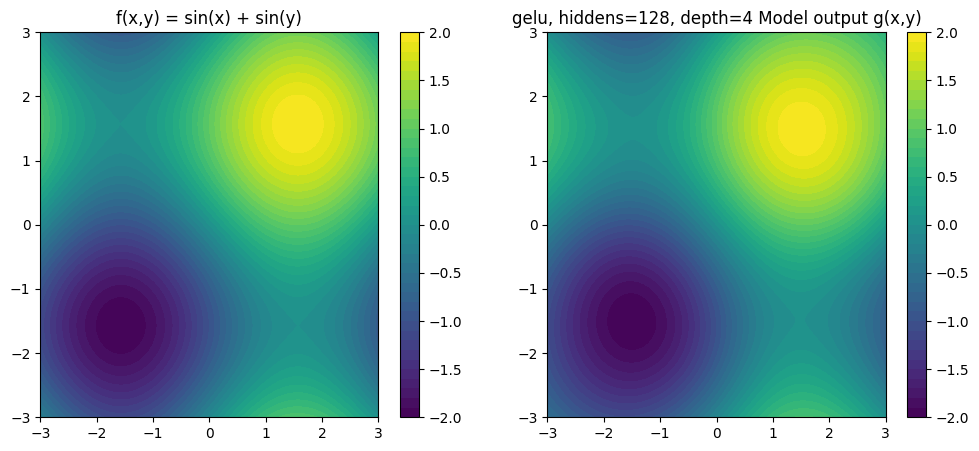

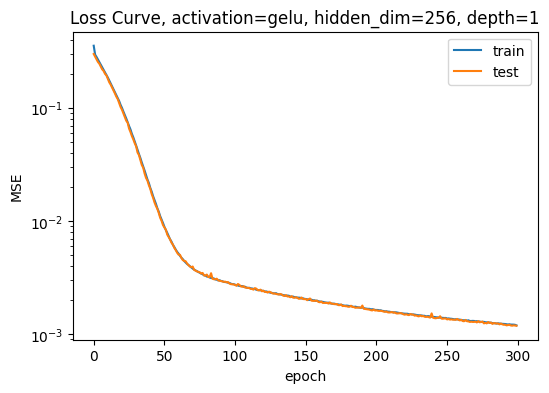

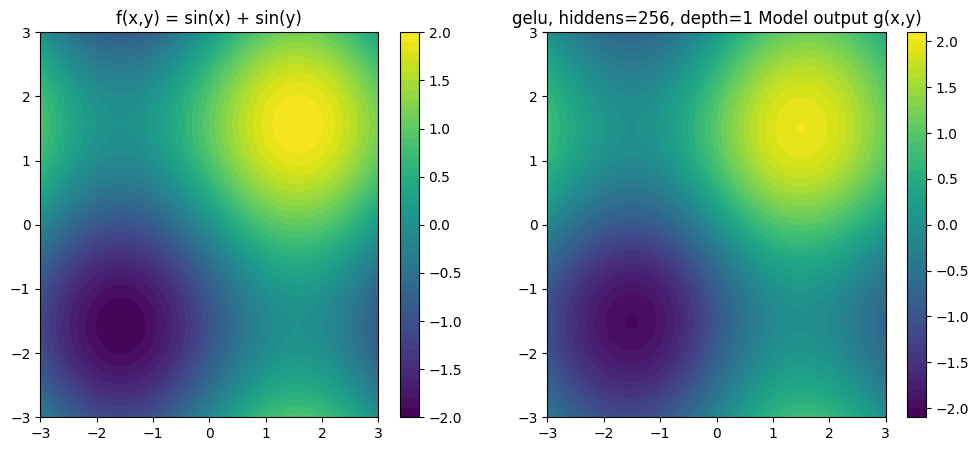

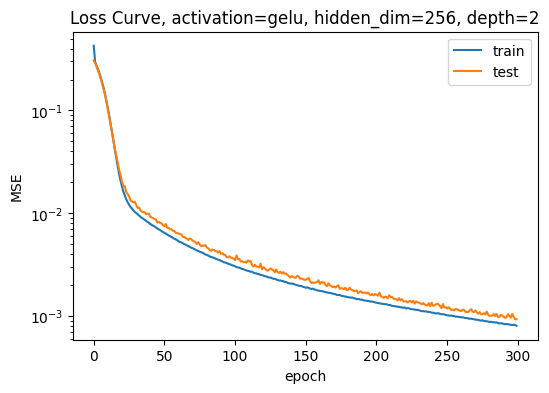

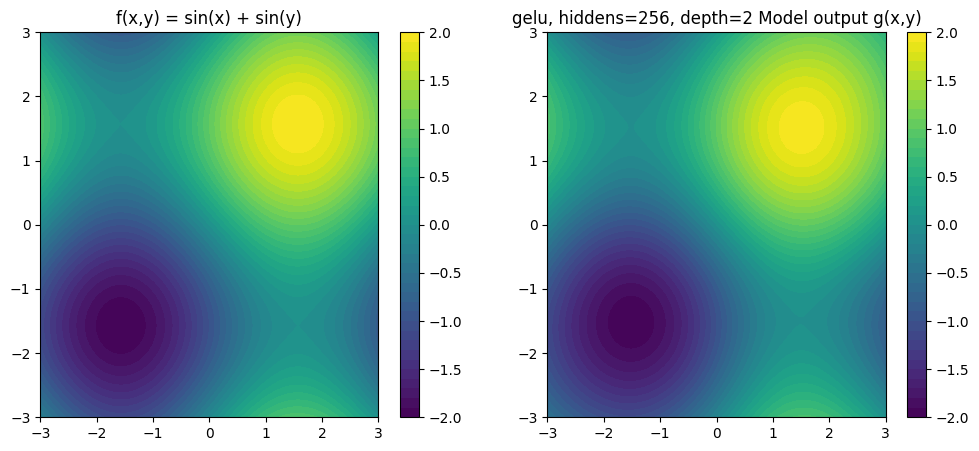

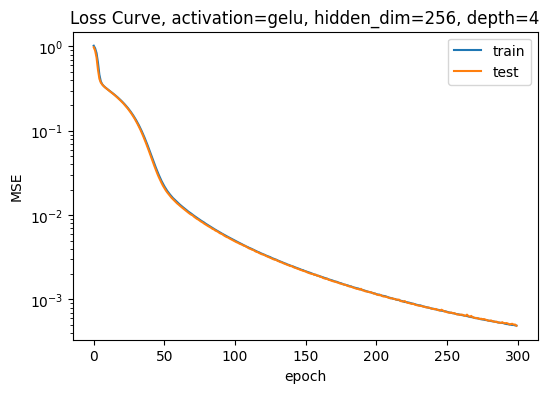

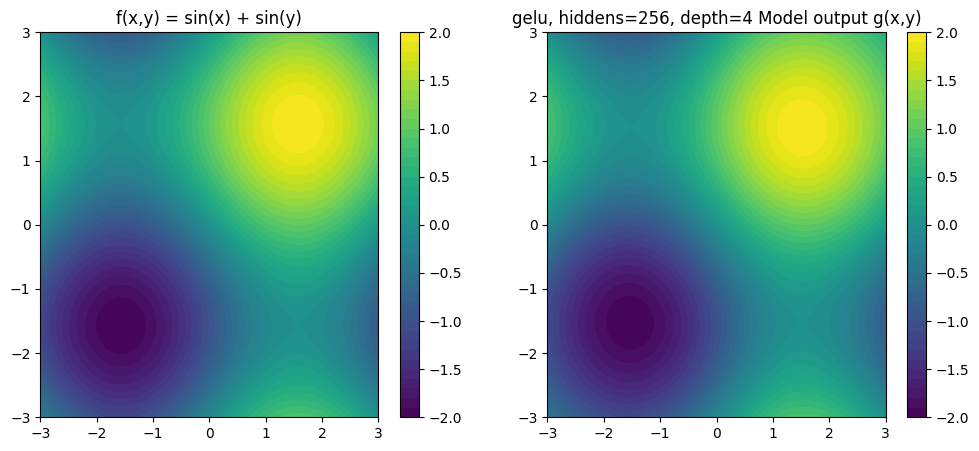

In [13]:
hidden_d = [32, 64, 128, 256]
hidden_layers = [1,2,4]
for hd in hidden_d:
    for hl in hidden_layers:
        dl_model = plot_loss_curve(best_activation,hidden_dim=hd,hidden_depth=hl)
        plot_contour_for_model(dl_model,best_activation + f", hiddens={hd}, depth={hl}")

## Problem 2

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### a)

In [15]:
sol_df = pd.read_csv("curated-solubility-dataset.csv")
print(sol_df.columns)


Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


### b)

In [16]:
features_start_at = list(sol_df.columns).index("MolWt")
X = sol_df.iloc[:, features_start_at:]
y = sol_df["Solubility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### c)

In [17]:
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

In [18]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims=(128, 128), l2_lambda=0.0, activation="relu"):
        super().__init__()
        act = {"relu": nn.ReLU(), "gelu": nn.GELU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation.lower()]
        layers, last = [], in_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(last, h), act])
            last = h
        layers.append(nn.Linear(last, 1))
        self.net = nn.Sequential(*layers)
        self.l2_lambda = l2_lambda
    def forward(self, x):
        return self.net(x)
    def loss(self, pred, target):
        mse = nn.functional.mse_loss(pred, target)
        l2 = sum(p.pow(2).sum() for p in self.parameters())
        return mse + self.l2_lambda * l2

In [19]:
def execute_model(hidden_dims, l2_lambda, activation_fxn):
    model = MLP(in_dim=X_train.shape[1], hidden_dims=hidden_dims, l2_lambda=l2_lambda, activation=activation_fxn)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for _ in range(200):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            model.loss(model(xb), yb).backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).squeeze()
    rmse = torch.sqrt(torch.mean((preds - y_test_t.squeeze()) ** 2))
    actual = y_test_t.squeeze()
    return rmse.item(), actual, preds


In [20]:
def plot_model_eval(actual,preds, model_name):
    plt.figure(figsize=(5, 5))
    plt.scatter(actual, preds, alpha=0.7)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], "k--",label="Perfect")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Solubility: actual vs predicted, Model={model_name}")
    plt.legend()
    plt.show()

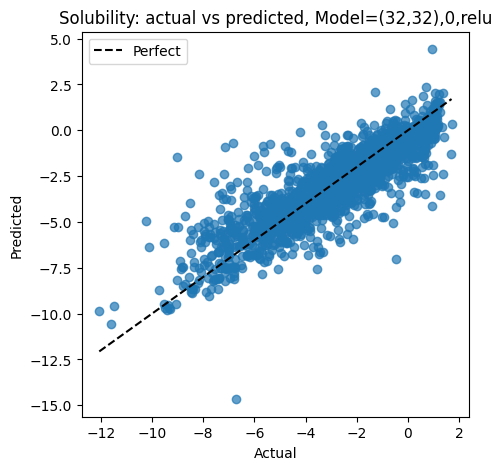

RMSE: 1.213222861289978


In [21]:
rmse, actual,preds = execute_model(hidden_dims=(32,32),l2_lambda=0, activation_fxn="relu")
plot_model_eval(actual,preds,"(32,32),0,relu")
print("RMSE:",rmse)

In HW1, the RMSE for the linear model was 1.654, so this is a significant improvement.

### d)

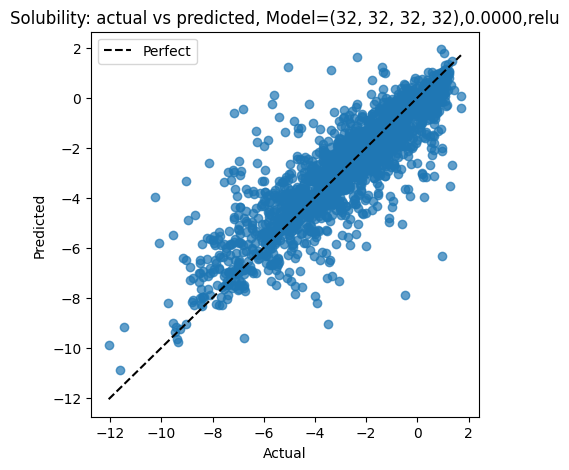

RMSE: 1.2215849161148071


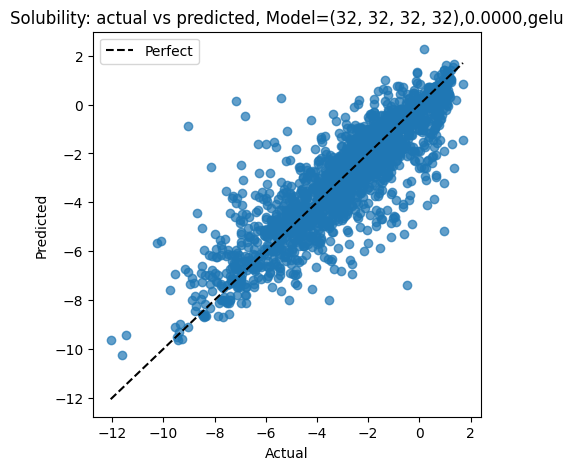

RMSE: 1.2032290697097778


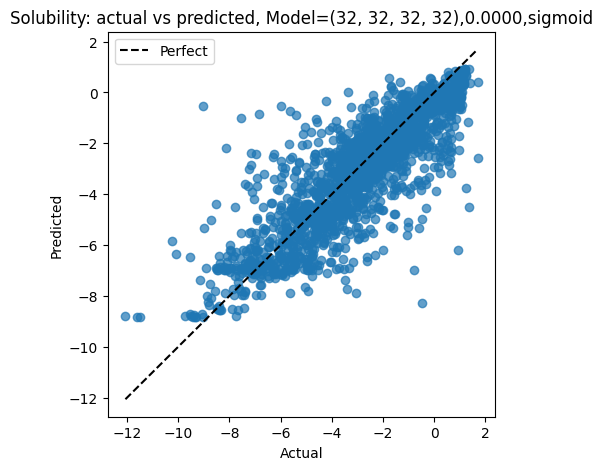

RMSE: 1.308143973350525


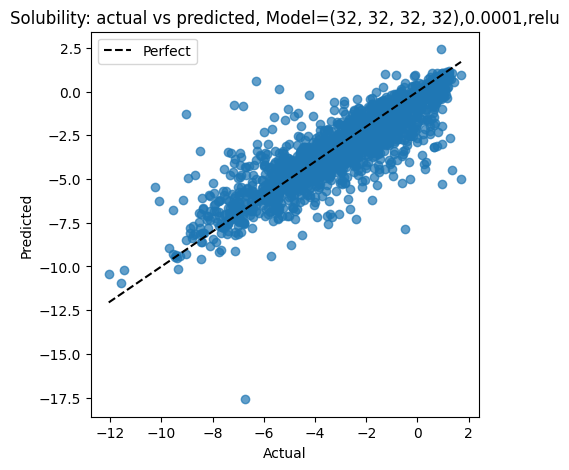

RMSE: 1.2408394813537598


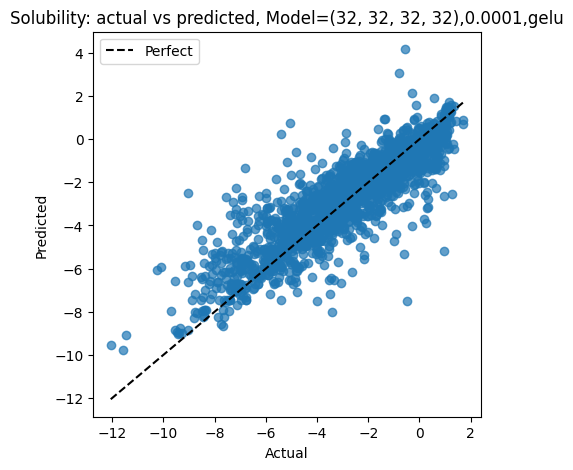

RMSE: 1.1812397241592407


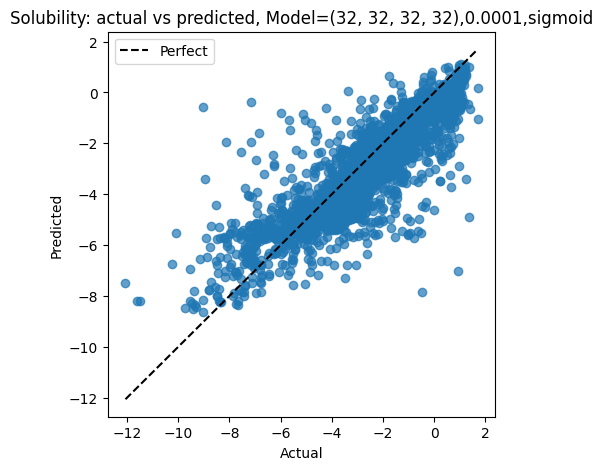

RMSE: 1.3139959573745728


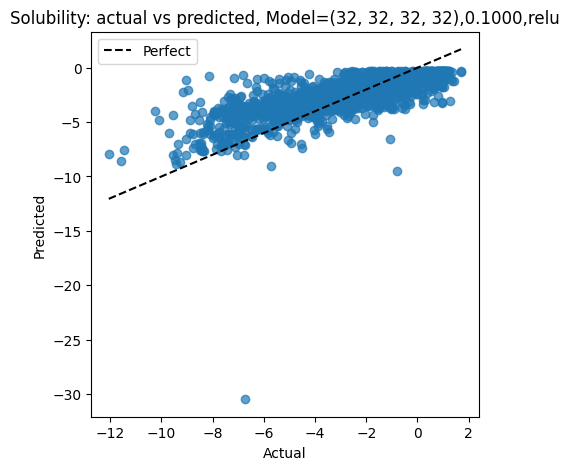

RMSE: 1.5934325456619263


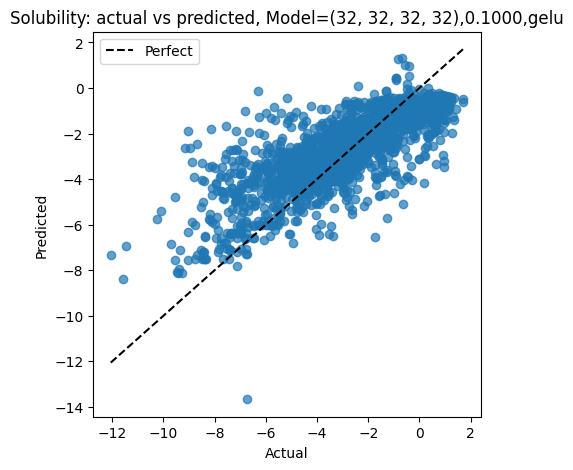

RMSE: 1.5082895755767822


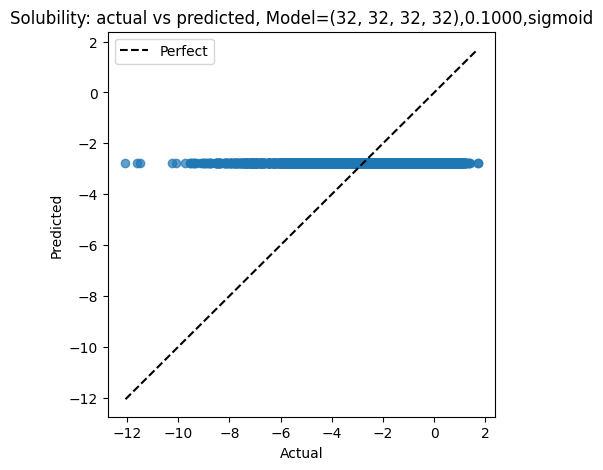

RMSE: 2.3511719703674316


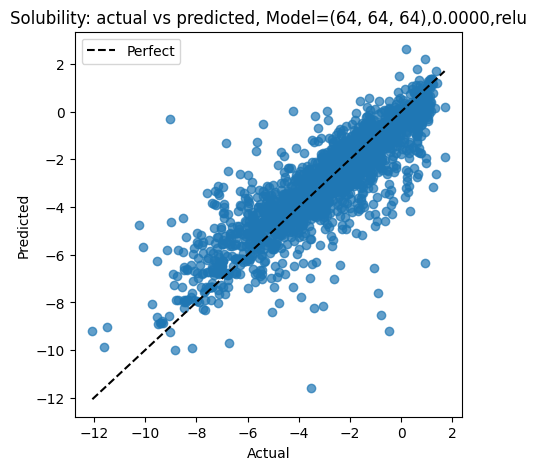

RMSE: 1.2248139381408691


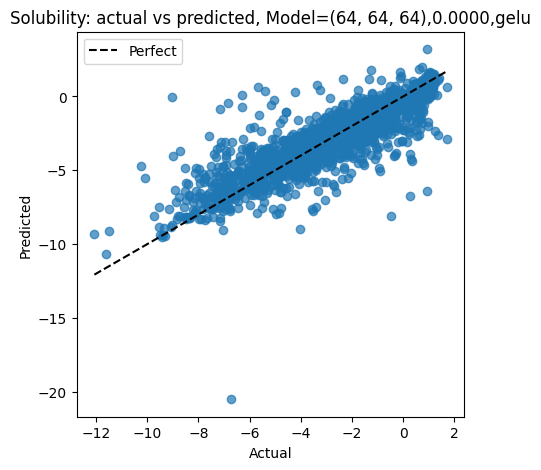

RMSE: 1.2700845003128052


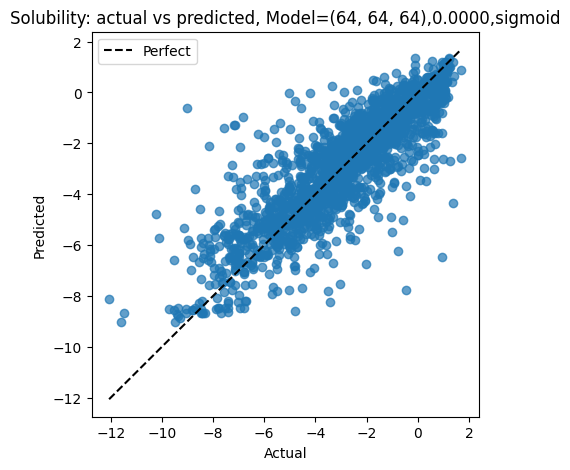

RMSE: 1.2670373916625977


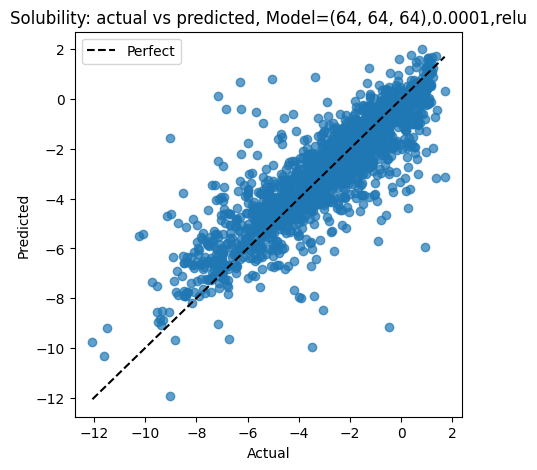

RMSE: 1.2081416845321655


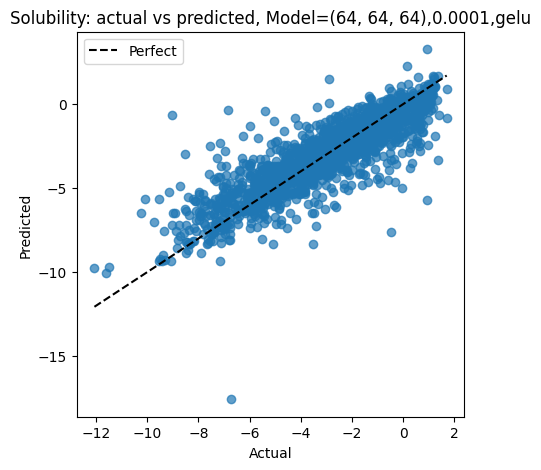

RMSE: 1.1816085577011108


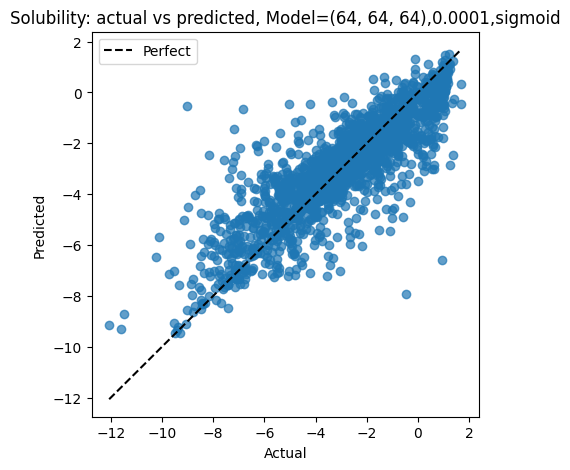

RMSE: 1.2379659414291382


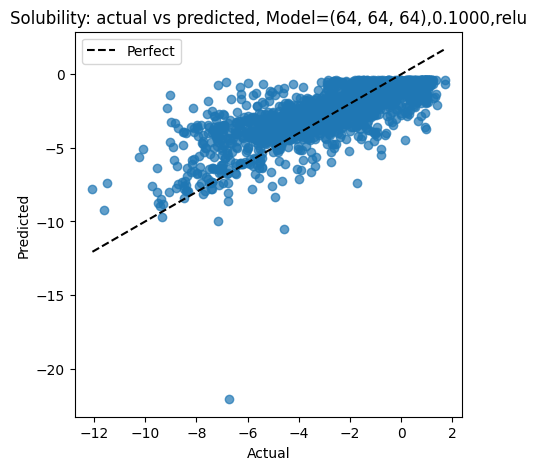

RMSE: 1.5665380954742432


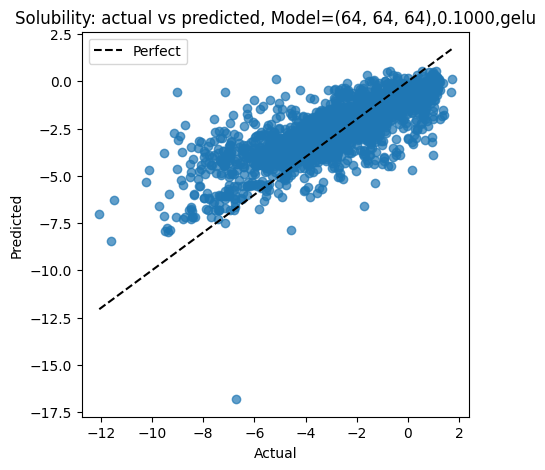

RMSE: 1.554309606552124


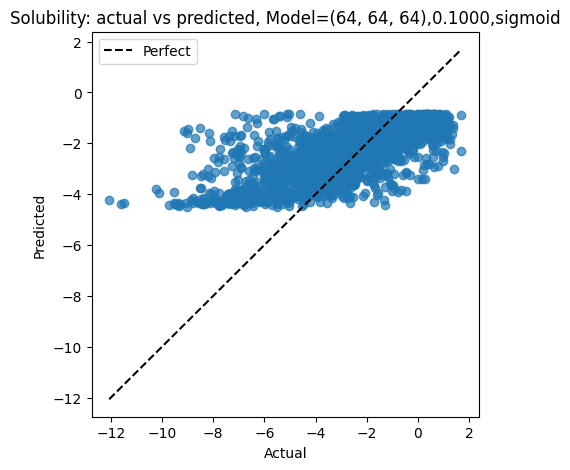

RMSE: 1.9076905250549316


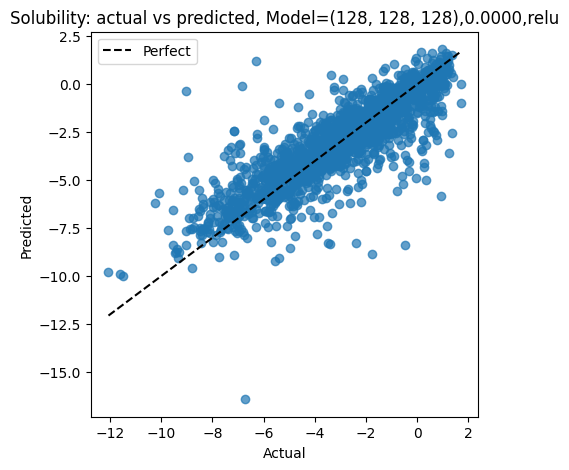

RMSE: 1.2356621026992798


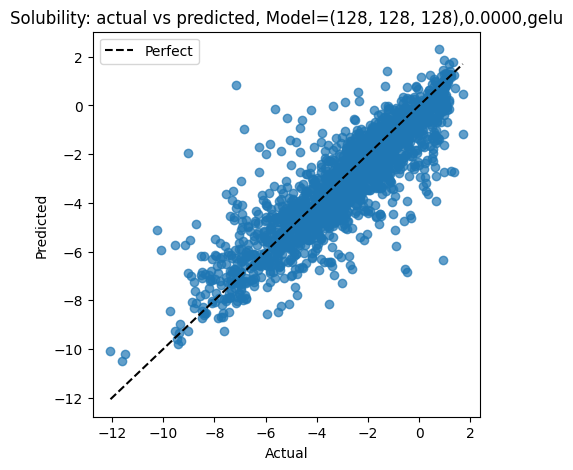

RMSE: 1.1957337856292725


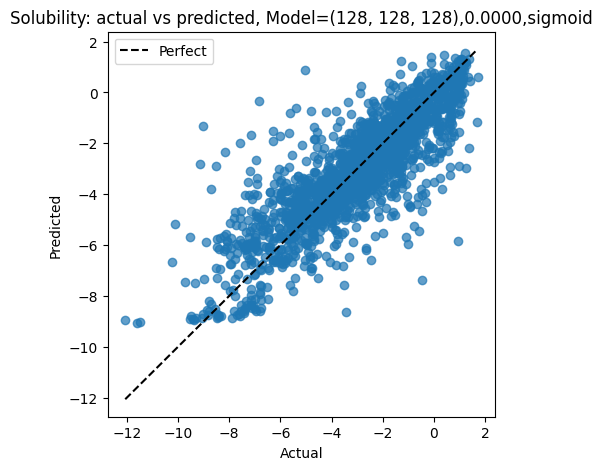

RMSE: 1.2760106325149536


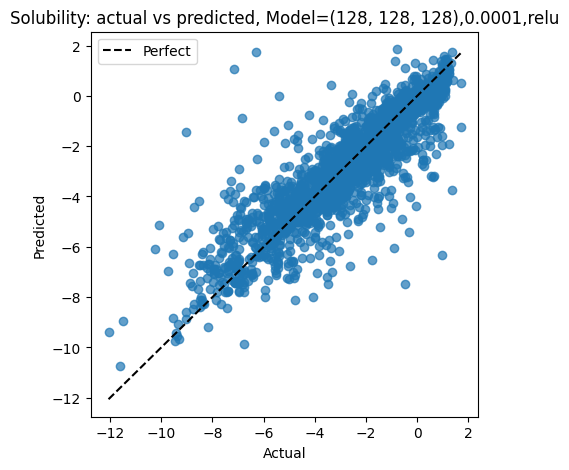

RMSE: 1.1744036674499512


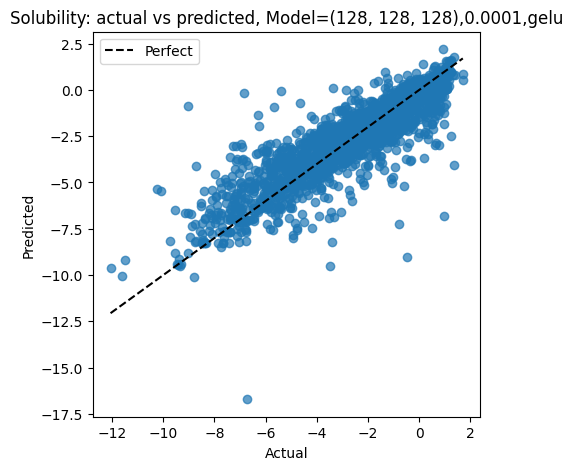

RMSE: 1.1974483728408813


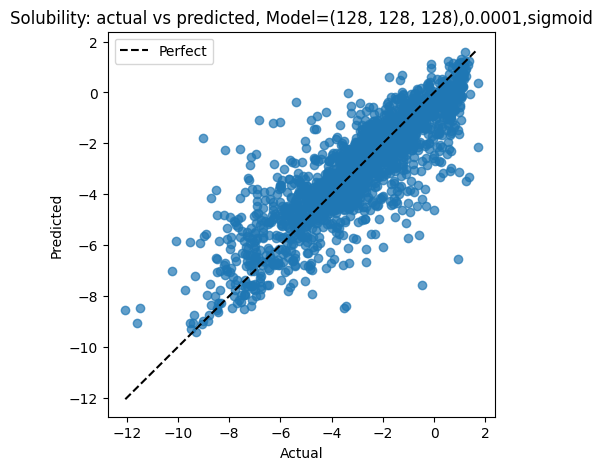

RMSE: 1.2469604015350342


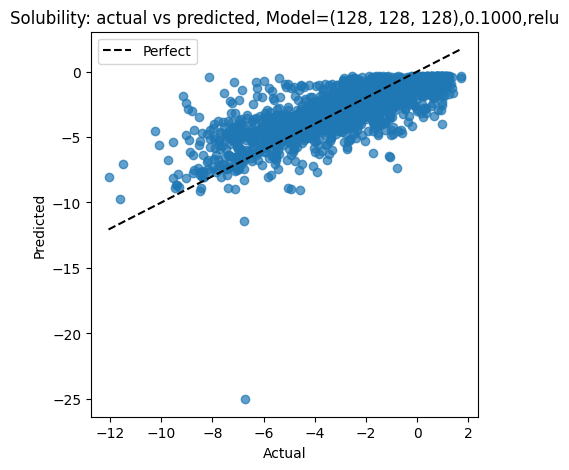

RMSE: 1.5298900604248047


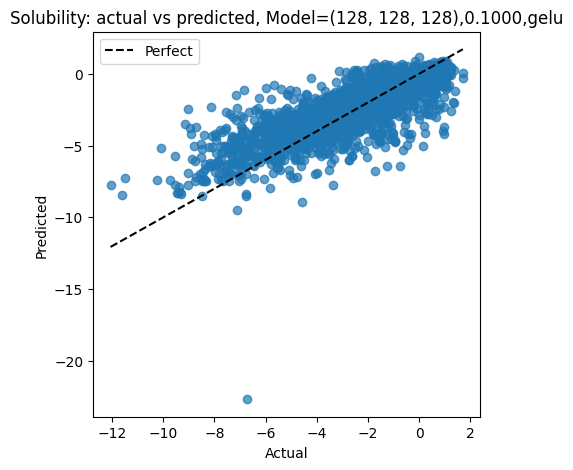

RMSE: 1.503129005432129


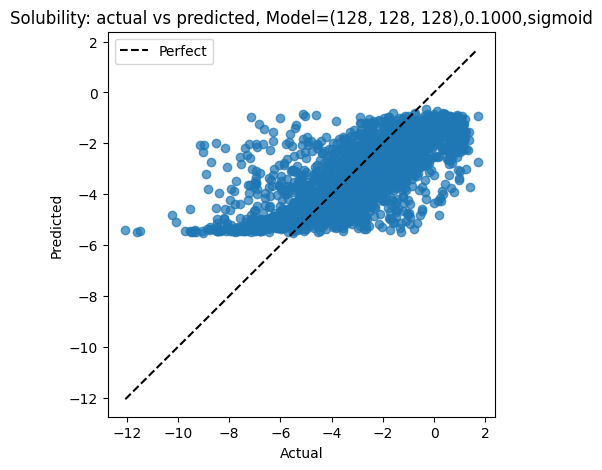

RMSE: 1.7769733667373657


In [22]:
for shape in [(32,32,32,32),(64,64,64),(128,128,128)]:
    for l2_lambda in [0,1e-4,1e-1]:
        for activation in ["relu","gelu","sigmoid"]:
            rmse, actual,preds = execute_model(hidden_dims=shape,l2_lambda=l2_lambda, activation_fxn=activation)
            plot_model_eval(actual,preds,str(shape)+f",{l2_lambda:.4f},"+activation)
            print("RMSE:",rmse)

Unsurprisingly, high amounts of regularization degraded the models, deeper models performed better, and RELU/GELU were the best activation functions (sigmoid would be limited to 1, and we're not classifying here)

## Problem 3

### a)

In [23]:
import tensorflow as tf
import keras

2025-04-21 14:43:18.473362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 14:43:18.484339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745264598.496976   31057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745264598.500270   31057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745264598.510861   31057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [24]:
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
features = features.astype("int32")
labels = labels.astype("int32")

i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

18453 examples


I0000 00:00:1745264600.289186   31057 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2175 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### b)

In [25]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
result = model.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out = model.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1745264601.768910   37038 service.cc:152] XLA service 0x7c245401f1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745264601.768936   37038 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-04-21 14:43:21.799253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745264602.043556   37038 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745264604.897028   37038 device_compiler.h:188] Compiled cluster usi

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5789 - loss: 1.1828
Binary crossentropy: 1.2056385278701782


### c)

#### Average Pooling

In [27]:
model_avg_pool = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True),
        tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"),
        tf.keras.layers.AveragePooling1D(pool_size=4),
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
        tf.keras.layers.AveragePooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)
model_avg_pool.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [28]:
result_avg_pool = model_avg_pool.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out_avg_pool = model_avg_pool.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out_avg_pool['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
2025-04-21 14:44:00.019068: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_885', 8 bytes spill stores, 8 bytes spill loads



116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.6090 - loss: 0.8486
Binary crossentropy: 0.8642994165420532


#### Many Layers

In [29]:
model_deep = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=21, output_dim=16, mask_zero=True),
        
        tf.keras.layers.Conv1D(16, 5, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling1D(4),
        
        tf.keras.layers.Conv1D(32, 5, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling1D(4),
        
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling1D(2),
        
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling1D(2),
        
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling1D(2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_deep.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [30]:
result_deep = model_deep.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out_deep = model_deep.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out_deep['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.6231 - loss: 0.8438
Binary crossentropy: 0.8997789025306702


#### Dropout

In [31]:
model_drop = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=21, output_dim=16, mask_zero=True),
    tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_drop.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
result_drop = model_drop.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out_drop = model_drop.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out_drop['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6405 - loss: 0.6256
Binary crossentropy: 0.6219781637191772


#### L2 Regularization

In [33]:
from tensorflow.keras import regularizers
model_reg = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=21, output_dim=16, mask_zero=True),
    tf.keras.layers.Conv1D(16, 5, activation="relu", padding="same",
                           kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling1D(pool_size=4),

    tf.keras.layers.Conv1D(16, 3, activation="relu", padding="same",
                           kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Conv1D(16, 3, activation="relu", padding="same",
                           kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu",
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dense(64, activation="relu",
                          kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_reg.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])


In [34]:
result_reg = model_reg.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out_reg = model_reg.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out_reg['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_14' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6577 - loss: 0.6555
Binary crossentropy: 0.6646630764007568


#### Dropout, Deeper, Average Pooling

In [35]:
model_all = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=21, output_dim=16, mask_zero=True),
    tf.keras.layers.Conv1D(32, 5, activation="relu", padding="same"),
    tf.keras.layers.AveragePooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_all.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
result_all = model_all.fit(train_data, validation_data=val_data, epochs=20, verbose=0)
out_all = model_all.evaluate(test_data, return_dict=True)
print("Binary crossentropy:", out_all['loss'])

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_17' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5411 - loss: 0.6905
Binary crossentropy: 0.6906733512878418


It seems the best improvements in the binary cross entropy come from L2 and dropout with dropout being better, but there are small improvements to be had for this model by increasing the number of convolutional layers and switching from max to average pooling. The combination of dropout+average pooling+deeper layers is not an improvement over just dropout from the model in b), however.